# TestCase3 - Convergence FEM / PINNs+Corr

**Problème :** size_param

In [1]:
# sélection du cas test
testcase = 3 
version = 1
param_num = 2

In [ ]:
assert testcase == 3 and version == 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from testcases.utils import create_tree

from testcases.geometry.geometry_2D import Square
from modfenics.fenics_expressions.fenics_expressions_3 import FExpr,AnisotropyExpr

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [4]:
from testcases.networks.test_2D.test_3.test_3_v1 import Run_laplacian2D,Poisson_2D
from testcases.problem.problem_2D import TestCase3
from modfenics.solver_fem.solver_fem_3 import FEMSolver
problem = TestCase3()

result_dir = "../../../results/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cpu


>> load network /home/u2/lecourtier/Article1/networks/test_fe3.pth
jsbdbshd
network loaded


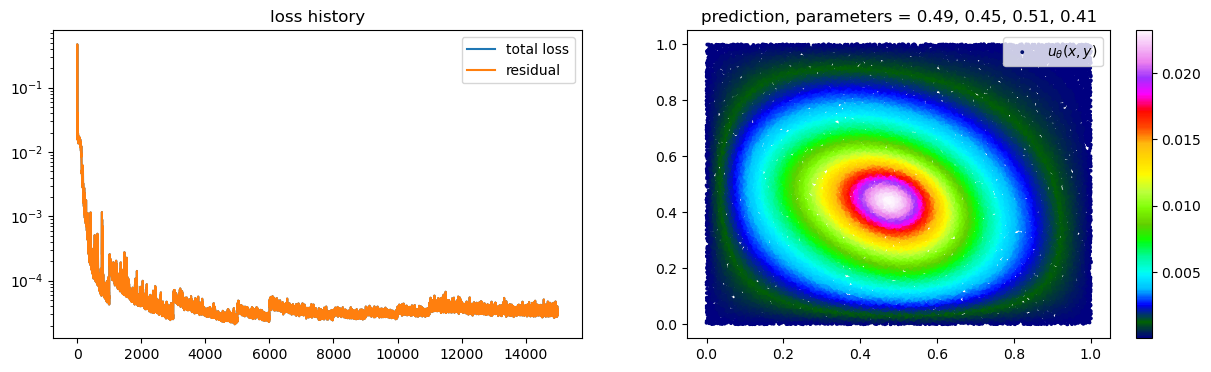

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.51 0.54 0.52 0.55]


## Solution de référence

In [7]:
from dolfin import *
prm = parameters["krylov_solver"]
prm["absolute_tolerance"] = 1e-13
prm["relative_tolerance"] = 1e-13

In [8]:
def create_ref_domain(deg):
    nb_vert = 1000

    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Square):
        box = np.array(problem.geometry.box)
        mesh_ref = df.RectangleMesh(df.Point(box[0,0], box[1,0]), df.Point(box[0,1], box[1,1]), nb_vert - 1, nb_vert - 1)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    print(V_ref.tabulate_dof_coordinates().shape)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref
    
def get_uref(param,deg):
    mesh_ref, V_ref, dx_ref = create_ref_domain(deg)
    boundary = "on_boundary"

    mat = AnisotropyExpr(param, degree=10, domain=mesh_ref, pb_considered=problem) 
    # mat = df.Expression((("eps * x[0]*x[0] + x[1]*x[1]","(eps - 1) * x[0] * x[1]"),
    #                 ("(eps - 1) * x[0] * x[1]","x[0]*x[0] + eps * x[1]*x[1]")), 
    #                 eps=param[3],
    #                 degree=10, 
    #                 domain=mesh_ref)
    
    f_expr = FExpr(param, degree=10, domain=mesh_ref, pb_considered=problem)
    
    g = df.Constant("0.0")
    bc = df.DirichletBC(V_ref, g, boundary)

    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(mat*df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    # solver = dol.KrylovSolver('cg', 'hypre_amg')
    # prm = solver.parameters
    # print(prm["absolute_tolerance"],prm["relative_tolerance"])
    # prm["absolute_tolerance"] = 1E-10
    # prm["relative_tolerance"] = 1E-10

    sol = df.Function(V_ref)
    # solver.solve(a==l, sol, bcs=bc)
    df.solve(a==l, sol, bcs=bc, solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

    return sol


In [9]:
savedir = result_dir + "u_ref/"
create_tree(savedir)
filename = savedir + f"u_ref_{param_num}.npy"

load_ref = True
if not load_ref or not os.path.exists(filename):
    u_ref = get_uref(param,deg=3)
    vct_u_ref = u_ref.vector().get_local()
    np.save(filename, vct_u_ref)  
else:
    vct_u_ref = np.load(filename)
    mesh_ref, V_ref, dx_ref = create_ref_domain(deg=3)
    u_ref = df.Function(V_ref)
    u_ref.vector()[:] = vct_u_ref

(8988004, 2)
hmax =  0.001415629191564785


In [10]:
# import dolfin as dol
# dol.list_linear_solver_methods()
# dol.list_krylov_solver_preconditioners()

## Convergence FEM

In [11]:
def read_csv(testcase,param_num,degree):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    df_FEM = pd.read_csv(csv_file)
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        print("Run FEM")
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        # tab_nb_vert_FEM = [2**i for i in range(3,8)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0,u_ref)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [12]:
degree = 3
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree3.csv


degree=1
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree1.csv
degree=2
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree2.csv
degree=3
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree3.csv


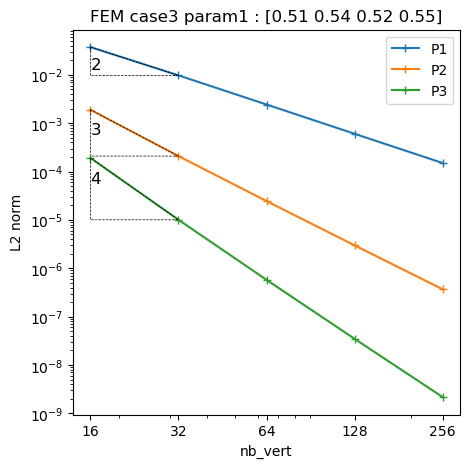

In [14]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_FEM[1],tab_err_FEM[1]]
    end = [tab_nb_vert_FEM[0],tab_err_FEM[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [15]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree1.csv
degree=2
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree2.csv
degree=3
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree3.csv


## Convergence PINNs+Corr

In [16]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [17]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]
        # tab_nb_vert_Corr = [5*i for i in range(2,7)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Corr.append(solver.h)
            
            V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs,u_ref)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

degree=1
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree1.csv
degree=2
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree2.csv
degree=3
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree3.csv


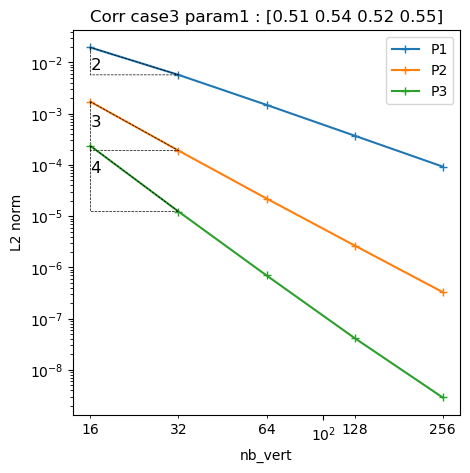

In [19]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_Corr[1],tab_err_Corr[1]]
    end = [tab_nb_vert_Corr[0],tab_err_Corr[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [20]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree1.csv
degree=2
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree2.csv
degree=3
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree3.csv


## Plots

degree=1
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree1.csv
degree=2
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree2.csv
degree=3
Read csv file ../results/test_2D/testcase3/cvg/FEM_case3_param1_degree3.csv
degree=1
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree1.csv
degree=2
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree2.csv
degree=3
Read csv file ../results/test_2D/testcase3/cvg/Corr_case3_param1_degree3.csv


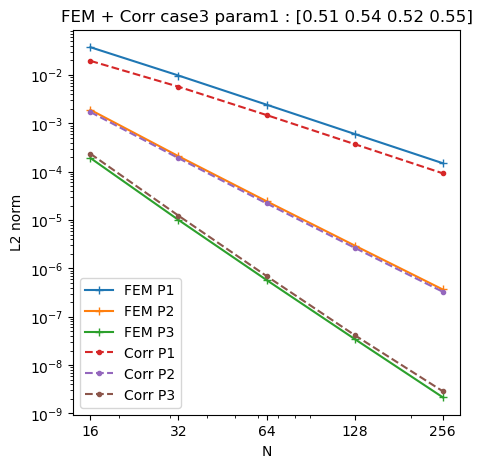

In [21]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')